# ЛР3

# Выбор целевого атрибута и оценка балансировки

In [2]:
import pandas as pd

import kagglehub

path = kagglehub.dataset_download("yaminh/smartphone-sale-dataset")

df = pd.read_csv(f"{path}/Sales.csv")
df.head()

median_price = df['Selling Price'].median()
df['high_end'] = (df['Selling Price'] > median_price).astype(int)

print("Распределение классов:")
print(df['high_end'].value_counts(normalize=True))

100%|██████████| 65.3k/65.3k [00:00<00:00, 24.7MB/s]

Extracting files...
Распределение классов:
high_end
0    0.500642
1    0.499358
Name: proportion, dtype: float64


# Подготовка признаков

In [3]:
# Извлечение и добавление новых признаков
df['RAM_GB'] = df['Memory'].str.extract(r'(\d+)').astype(float)
df['Storage_GB'] = df['Storage'].str.extract(r'(\d+)').astype(float)
df['total_storage_GB'] = df['RAM_GB'] + df['Storage_GB']
df['value_score'] = df['Rating'] / df['Selling Price']

# Выбор признаков и целевой переменной
features = ['RAM_GB', 'Storage_GB', 'Rating', 'value_score']
X = df[features].copy()
y = df['high_end']

# Заполнение пропусков медианой
X.fillna(X.median(), inplace=True)
X.head()

,RAM_GB,Storage_GB,Rating,value_score
0,8.0,128.0,4.3,0.000222
1,2.0,16.0,3.8,0.000373
2,2.0,64.0,4.4,0.000629
3,4.0,64.0,4.2,0.000323
4,4.0,64.0,4.6,0.000092


# Разбиение на обучающую и тестовую выборки

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Разбиение с стратификацией
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Масштабирование для kNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение моделей

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# kNN-классификатор
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
y_prob_knn = knn.predict_proba(X_test_scaled)[:,1]

# Дерево решений
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:,1]

# Оценка качества и ROC-кривые


=== kNN ===
Accuracy : 0.9850267379679144
Precision: 0.9808917197452229
Recall   : 0.9892933618843683
F1-score : 0.9850746268656716
ROC AUC  : 0.9959598455315799
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       468
           1       0.98      0.99      0.99       467

    accuracy                           0.99       935
   macro avg       0.99      0.99      0.99       935
weighted avg       0.99      0.99      0.99       935


=== Decision Tree ===
Accuracy : 0.9957219251336898
Precision: 0.9936034115138592
Recall   : 0.9978586723768736
F1-score : 0.9957264957264957
ROC AUC  : 0.9956830286059408
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       468
           1       0.99      1.00      1.00       467

    accuracy                           1.00       935
   macro avg       1.00      1.00      1.00       935
weighted avg       1.00      1.00      1.00       935



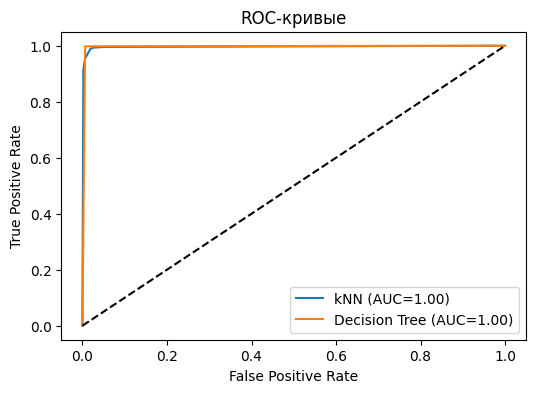

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    classification_report
)

def eval_model(name, y_true, y_pred, y_prob):
    print(f"\n=== {name} ===")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    print("ROC AUC  :", roc_auc_score(y_true, y_prob))
    print(classification_report(y_true, y_pred))
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_true, y_prob):.2f})")

plt.figure(figsize=(6,4))
eval_model('kNN', y_test, y_pred_knn, y_prob_knn)
eval_model('Decision Tree', y_test, y_pred_dt, y_prob_dt)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые')
plt.legend()
plt.show()

# Выводы
Классы **high_end** сбалансированы: 50.06% бюджетные, 49.94% премиальные

**kNN**:  
Accuracy = 0.9850  
Precision = 0.9808  
Recall = 0.9892  
F1-score = 0.9850  
ROC AUC = 0.9959

**Дерево решений**:  
Accuracy = 0.9957  
Precision = 0.9936  
Recall = 0.9978  
F1-score = 0.9957  
ROC AUC = 0.9956  

Оба алгоритма показывают высокую точность, дерево решений немного превосходит kNN по большинству метрик, но разница невелика
Высокие показатели указывают на чёткое разделение классов по выбранным признакам
